In [1]:
import pandas as pd 
import os
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings 
import datetime as dt
warnings.filterwarnings('ignore')

# Import the NN libs 
from keras.models import Sequential
from keras.layers import Dense 
from keras.layers import LSTM 
from keras.layers import Dropout 

from pylab import rcParams
rcParams['figure.figsize'] = 8, 10

%matplotlib inline
%config IPCompleter.greedy=True
%config Completer.use_jedi = False
os.chdir('C:/Users/Ruair/Google Drive/Code/Python/Time-series-forecasting-/Data')

Using TensorFlow backend.


In [2]:
dat = pd.read_csv('ts_with_ei.csv')

In [3]:
dat = pd.read_csv('ts_with_ei.csv')
dat.drop(['Unnamed: 0'], axis=1)
dat = dat.drop_duplicates(keep = 'first', subset = 'Date')
dat['Date'] = pd.to_datetime(dat['Date'])
dat=dat.iloc[:725,].reset_index()

In [4]:
dat.head()

,index,Unnamed: 0,Unnamed: 0.1,Date,HRRminsSED,HRRminsLIGHT,HRRminsMOD,HRRminsVIG,steps,tdee,...,awake_duration,minutes_asleep,efficiency,weight,Age,Height,PAEE,RMR,Day_no,EI
0,0,0.0,0.0,2017-03-06,1181.000000,227.000000,19.000000,13.0,8853.000000,2295.201470,...,0.0,486.0,96.0,71.690598,51.0,168.5,943.076470,1352.125,0.0,0.0
1,1,1.0,1.0,2017-04-06,1268.825397,145.952381,14.222222,11.0,7822.888889,2138.548089,...,7.0,414.0,95.0,71.636709,51.0,168.5,786.423089,1352.125,1.0,NaN
2,2,2.0,2.0,2017-05-06,1275.163265,145.836735,19.000000,0.0,9137.367347,2116.494561,...,0.0,469.0,97.0,71.582830,51.0,168.5,764.369561,1352.125,2.0,NaN
3,3,3.0,3.0,2017-06-06,1295.000000,105.000000,33.000000,7.0,5372.000000,1964.860080,...,0.0,489.0,98.0,71.528963,51.0,168.5,612.735080,1352.125,3.0,NaN
4,4,4.0,4.0,2017-07-06,1341.333333,73.333333,25.333333,0.0,4696.000000,1826.989867,...,3.0,465.0,97.0,71.475107,51.0,168.5,487.864867,1339.125,4.0,NaN


In [5]:
dat = dat[['tdee', 'awake_count', 'awake_duration', 'minutes_asleep',
       'efficiency', 'weight', 'PAEE', 'EI']]

In [6]:
# Set baseline to 0 
dat['EI'][0] = 0
dat['EI_i'] = np.where(dat['EI'].notnull(), True, False)

In [7]:
# Interpolate linearly 
for c in dat.columns: 
    dat[c] = dat[c].interpolate()

dat.head(14)

,tdee,awake_count,awake_duration,minutes_asleep,efficiency,weight,PAEE,EI,EI_i
0,2295.201470,0.0,0.0,486.0,96.0,71.690598,943.076470,0.000000,True
1,2138.548089,2.0,7.0,414.0,95.0,71.636709,786.423089,-104.214625,False
2,2116.494561,0.0,0.0,469.0,97.0,71.582830,764.369561,-208.429250,False
3,1964.860080,0.0,0.0,489.0,98.0,71.528963,612.735080,-312.643875,False
4,1826.989867,1.0,3.0,465.0,97.0,71.475107,487.864867,-416.858500,False
5,2088.672020,1.0,1.0,435.0,98.0,71.421264,778.547020,-521.073125,False
6,1755.604400,0.0,0.0,461.0,99.0,71.367434,454.479400,-625.287750,False
7,2083.692900,1.0,3.0,376.0,97.0,71.313617,778.567900,-729.502375,True
8,2724.919833,0.0,0.0,483.0,98.0,71.259816,1451.794833,-751.281852,False
9,1787.559900,0.0,0.0,533.0,97.0,71.206030,511.434900,-773.061328,False


In [8]:
# add gausdsian noise to the interpolated values 
orig=dat[dat['EI_i'] == True] 
interpolated=dat[dat['EI_i'] == False] 
interpolated['noise'] = np.random.normal(0,50,len(interpolated))
interpolated['EI'] = interpolated['EI'] + interpolated['noise']
interpolated = interpolated.drop( columns = ['noise'],axis = 1)
dat=pd.merge(orig, interpolated, how = 'outer')

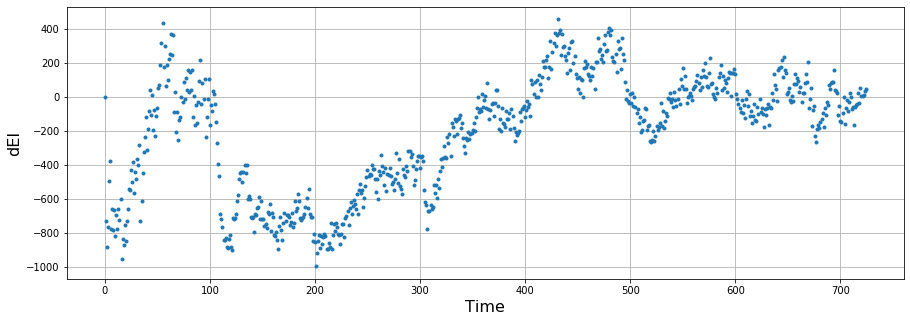

In [9]:
rcParams['figure.figsize'] = 15, 5
plt.plot(dat.EI, marker='.', linestyle='None')
plt.grid(True)
plt.ylabel('dEI', fontsize=16)
plt.xlabel('Time', fontsize=16); 

Data Preparation for univariate LSTM 

In [10]:
dat=dat[['EI']]
dat= dat[dat.EI.notnull()]
sc = MinMaxScaler(feature_range = (0, 1))
s = sc.fit_transform(dat)

In [11]:
test = s[len(s) - 4:len(s) - 1] # 
s_t = s[:len(s) - 1]
final=s[len(s) - 1:]

In [12]:
def split(series, time_steps):
    X, y = list(), list()
    for i in range(len(series)):
        end_ind = i + time_steps # get end
        if end_ind > len(series)-1:
            break
        X.append(series[i:end_ind]) # append to the list
        y.append(series[end_ind]) # append to the list
    return np.array(X), np.array(y)

n_steps = 3
X, y = split(s_t, n_steps)
for i in range(len(X)): # plot the data 
    print(X[i], y[i])

[[0.68523922]
 [0.18386433]
 [0.07908361]] [0.16155763]
[[0.18386433]
 [0.07908361]
 [0.16155763]] [0.3443005]
[[0.07908361]
 [0.16155763]
 [0.3443005 ]] [0.42677451]
[[0.16155763]
 [0.3443005 ]
 [0.42677451]] [0.15106273]
[[0.3443005 ]
 [0.42677451]
 [0.15106273]] [0.23353674]
[[0.42677451]
 [0.15106273]
 [0.23353674]] [0.14768138]
[[0.15106273]
 [0.23353674]
 [0.14768138]] [0.23015539]
[[0.23353674]
 [0.14768138]
 [0.23015539]] [0.12383001]
[[0.14768138]
 [0.23015539]
 [0.12383001]] [0.20630402]
[[0.23015539]
 [0.12383001]
 [0.20630402]] [0.14979003]
[[0.12383001]
 [0.20630402]
 [0.14979003]] [0.23226404]
[[0.20630402]
 [0.14979003]
 [0.23226404]] [0.18979764]
[[0.14979003]
 [0.23226404]
 [0.18979764]] [0.27227165]
[[0.23226404]
 [0.18979764]
 [0.27227165]] [0.02965673]
[[0.18979764]
 [0.27227165]
 [0.02965673]] [0.11213074]
[[0.27227165]
 [0.02965673]
 [0.11213074]] [0.08645279]
[[0.02965673]
 [0.11213074]
 [0.08645279]] [0.1689268]
[[0.11213074]
 [0.08645279]
 [0.1689268 ]] [0.1018

In [13]:
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1)) 
model.compile(optimizer='adam', loss='mse') 

model.fit(X, 
          y, 
          epochs=100)


Epoch 1/100
721/721 [==============================] - 0s 650us/step - loss: 0.2053
Epoch 2/100
721/721 [==============================] - 0s 112us/step - loss: 0.0325
Epoch 3/100
721/721 [==============================] - 0s 107us/step - loss: 0.0122
Epoch 4/100
721/721 [==============================] - 0s 108us/step - loss: 0.0087
Epoch 5/100
721/721 [==============================] - 0s 107us/step - loss: 0.0067
Epoch 6/100
721/721 [==============================] - 0s 110us/step - loss: 0.0051
Epoch 7/100
721/721 [==============================] - 0s 109us/step - loss: 0.0044
Epoch 8/100
721/721 [==============================] - 0s 104us/step - loss: 0.0043
Epoch 9/100
721/721 [==============================] - 0s 103us/step - loss: 0.0041
Epoch 10/100
721/721 [==============================] - 0s 112us/step - loss: 0.0041
Epoch 11/100
721/721 [==============================] - 0s 111us/step - loss: 0.0041
Epoch 12/100
721/721 [==============================] - 0s 108us/step - l

721/721 [==============================] - 0s 105us/step - loss: 0.0033
Epoch 95/100
721/721 [==============================] - 0s 107us/step - loss: 0.0033
Epoch 96/100
721/721 [==============================] - 0s 111us/step - loss: 0.0033
Epoch 97/100
721/721 [==============================] - 0s 108us/step - loss: 0.0034
Epoch 98/100
721/721 [==============================] - 0s 105us/step - loss: 0.0033
Epoch 99/100
721/721 [==============================] - 0s 106us/step - loss: 0.0038
Epoch 100/100
721/721 [==============================] - 0s 104us/step - loss: 0.0033


In [14]:
test = test.reshape((1, n_steps, n_features))

In [15]:
pred = model.predict(test, verbose=0)

In [16]:
pred

array([[0.7132059]], dtype=float32)

In [17]:
s_un = sc.inverse_transform(s)
pred_un = sc.inverse_transform(pred)
final_un = sc.inverse_transform(final)

In [18]:
def plot_series(series, pred=None, final=None):
    plt.plot(series, "-")
    plt.grid(True)
    plt.ylabel('dEI', fontsize=16)
    plt.xlabel('Time', fontsize=16)
    if pred is not None:
        plt.plot(len(series), pred, "ro")
    if final is not None:
        plt.plot(len(series), final, "bx")

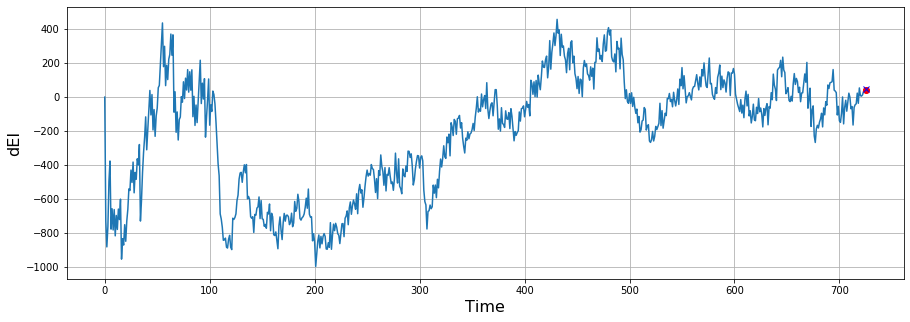

In [19]:
rcParams['figure.figsize'] = 15, 5
plot_series(s_un, pred_un, final_un);

In [20]:
diff=final_un- pred_un
print('Error in prediction of: ' , diff.item(0), 'kcal/day')

Error in prediction of:  9.949211373420376 kcal/day


# Multiple output 

In [21]:
# Scale the data 
sc = MinMaxScaler(feature_range = (0, 1))
scaled = sc.fit_transform(dat[['EI']])
dat['EI_s'] = scaled
s=dat.EI_s.values

In [22]:
# set data for lstm 
def mult_lstm_seq(series, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(series)):
        ind = i + n_steps_in
        end_ind = ind + n_steps_out
        if end_ind > len(series):
            break
        X.append(series[i:ind])
        y.append(series[ind:end_ind])
    return np.array(X), np.array(y)

In [33]:
# Prepare the dataset for lstm 
n_steps_in, n_steps_out = 21, 7

In [34]:
# Define the training, testing data 
test = s[len(s) - (n_steps_in + n_steps_out):len(s) - n_steps_out] 
s_t = s[:len(s) - n_steps_out]
final=s[len(s) - n_steps_out:]

X, y = mult_lstm_seq(s_t, n_steps_in, n_steps_out)
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features)) 

In [35]:
# define model - deeper network 
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')

In [36]:
model.fit(X, y, epochs=100, verbose=1)


Epoch 1/100
691/691 [==============================] - 1s 1ms/step - loss: 0.2078
Epoch 2/100
691/691 [==============================] - 1s 762us/step - loss: 0.0213
Epoch 3/100
691/691 [==============================] - 1s 761us/step - loss: 0.0159
Epoch 4/100
691/691 [==============================] - 1s 773us/step - loss: 0.0148 0s - loss: 0.015
Epoch 5/100
691/691 [==============================] - 1s 787us/step - loss: 0.0136
Epoch 6/100
691/691 [==============================] - 1s 785us/step - loss: 0.0128
Epoch 7/100
691/691 [==============================] - 1s 784us/step - loss: 0.0121
Epoch 8/100
691/691 [==============================] - 1s 784us/step - loss: 0.0118
Epoch 9/100
691/691 [==============================] - 1s 779us/step - loss: 0.0120
Epoch 10/100
691/691 [==============================] - 1s 795us/step - loss: 0.0112
Epoch 11/100
691/691 [==============================] - 1s 789us/step - loss: 0.0110
Epoch 12/100
691/691 [==============================] - 1s 

691/691 [==============================] - 1s 751us/step - loss: 0.0068
Epoch 98/100
691/691 [==============================] - 1s 735us/step - loss: 0.0067
Epoch 99/100
691/691 [==============================] - 1s 741us/step - loss: 0.0067
Epoch 100/100
691/691 [==============================] - 1s 748us/step - loss: 0.0072


In [37]:
test = test.reshape((1, n_steps_in, n_features))
pred = model.predict(test, verbose=0)

In [38]:
s

array([0.68523922, 0.18386433, 0.07908361, 0.16155763, 0.3443005 ,
       0.42677451, 0.15106273, 0.23353674, 0.14768138, 0.23015539,
       0.12383001, 0.20630402, 0.14979003, 0.23226404, 0.18979764,
       0.27227165, 0.02965673, 0.11213074, 0.08645279, 0.1689268 ,
       0.10182973, 0.18430374, 0.231387  , 0.31386101, 0.3074647 ,
       0.38993872, 0.33994013, 0.42241414, 0.29799148, 0.3804655 ,
       0.35308223, 0.43555624, 0.41094692, 0.49342093, 0.18370874,
       0.26618276, 0.37992641, 0.46240042, 0.52278866, 0.60526267,
       0.47211332, 0.55458733, 0.62982599, 0.7123    , 0.61314918,
       0.69562319, 0.5523249 , 0.63479892, 0.52656196, 0.60903598,
       0.64090342, 0.72337744, 0.73258528, 0.8150593 , 0.90299785,
       0.98547187, 0.80852887, 0.89100289, 0.73175327, 0.81422728,
       0.75627425, 0.83874826, 0.85802533, 0.94049934, 0.85484989,
       0.9373239 , 0.62434503, 0.70681905, 0.54288502, 0.62535903,
       0.51169731, 0.59417132, 0.60471168, 0.68718569, 0.66486

In [39]:
s_un = sc.inverse_transform(s.reshape(-1, 1))
pred_un = sc.inverse_transform(pred)
final_un = sc.inverse_transform(final.reshape(-1, 1))

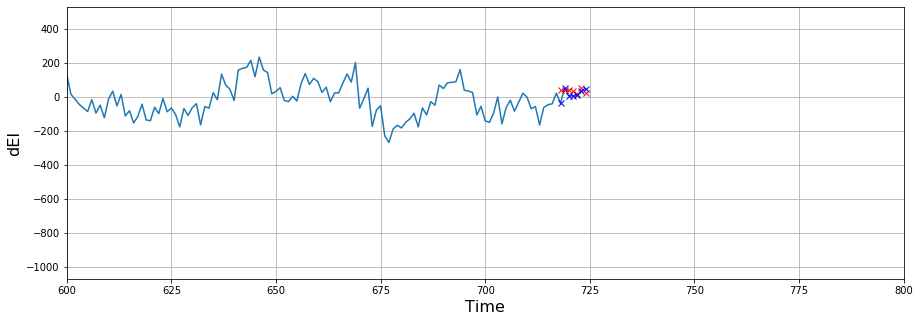

In [45]:
rcParams['figure.figsize'] = 15, 5

plt.plot(s_un, "-")
plt.grid(True)
plt.ylabel('dEI', fontsize=16)
plt.xlabel('Time', fontsize=16)
plt.xlim([600, 800]) 
for i in range(len(final)):
    plt.plot(len(s_t)+(i), pred_un[0][i], "rx")
    plt.plot(len(s_t)+(i), final_un[i], "bx")
    
plt.show();

In [41]:
for i in range(len(final)):
    diff =  - pred_un[0][i] -final_un[i]
    print('Deviation at prediction point', i, ' is equal to: ' , diff.item(0), 'kcal/day')

Deviation at prediction point 0  is equal to:  -77.00088774161992 kcal/day
Deviation at prediction point 1  is equal to:  14.500476578683639 kcal/day
Deviation at prediction point 2  is equal to:  -31.241940661731483 kcal/day
Deviation at prediction point 3  is equal to:  -27.205713040355203 kcal/day
Deviation at prediction point 4  is equal to:  -7.0701560600501505 kcal/day
Deviation at prediction point 5  is equal to:  -19.855179293375905 kcal/day
Deviation at prediction point 6  is equal to:  23.866922631354946 kcal/day


In [42]:
print('RMSE over 7 day forecast', np.sqrt(np.mean((final_un-pred_un)**2)))

RMSE over 7 day forecast 35.29083421384423
